In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sal = pd.read_csv('merged_cbsa_salary.csv')
# note: using Andrew's census data here - Thanks Andrew!

In [3]:
sal.head(5)

,Unnamed: 0,zip,function.,sup1,sup2,sup3,sup4,sup5,salary,gender,...,Types.of.Health.Insurance.Coverage.by.Age..65.years.and.over..With.two.or.more.types.of.health.insurance.coverage.With.direct.purchase.and.Medicare.coverage,Types.of.Health.Insurance.Coverage.by.Age..65.years.and.over..With.two.or.more.types.of.health.insurance.coverage.With.Medicare.and.Medicaid.means.tested.public.coverage,Types.of.Health.Insurance.Coverage.by.Age..65.years.and.over..With.two.or.more.types.of.health.insurance.coverage.Other.private.only.combinations,Types.of.Health.Insurance.Coverage.by.Age..65.years.and.over..With.two.or.more.types.of.health.insurance.coverage.Other.public.only.combinations,Types.of.Health.Insurance.Coverage.by.Age..65.years.and.over..With.two.or.more.types.of.health.insurance.coverage.Other.coverage.combinations,Types.of.Health.Insurance.Coverage.by.Age..65.years.and.over..No.health.insurance.coverage,married,divorced,bad_english,poverty
0,1,1003,position1,4,4,0,0,0,77308,M,...,16686,9442,0,1289,18508,194,42.023943,10.485747,7.930932,16.801532
1,2,1003,position15,0,2,0,60,0,38120,M,...,16686,9442,0,1289,18508,194,42.023943,10.485747,7.930932,16.801532
2,3,1003,position15,1,0,0,60,2,55335,W,...,16686,9442,0,1289,18508,194,42.023943,10.485747,7.930932,16.801532
3,4,1003,position4,1,0,0,35,1,70863,W,...,16686,9442,0,1289,18508,194,42.023943,10.485747,7.930932,16.801532
4,5,1003,position9,1,0,0,100,0,56557,M,...,16686,9442,0,1289,18508,194,42.023943,10.485747,7.930932,16.801532


In [4]:
print(sal.shape)

(2222, 201)


In [5]:
sal['missingSalary'] = pd.isnull(sal['salary'])
sal2 = sal[(sal.missingSalary == False)]
# elminates missing Y values

In [6]:
# list of X vars to include
X_numeric_features = ['sup1', 'sup2', 'sup3', 'sup4', 'sup5', 'disabled', 'yearsinposition', 
         'yearsinprofession', 'age', 'cred1', 'cred2', 'inst1', 'inst2', 'inst3', 'inst4', 'inst5', 'instbudget', 'instsize']
X_numeric = sal2[X_numeric_features]
X_categorical_features = ['function.', 'gender', 'race', 'highestdegree', 'category', 'insttype']
X_categorical = sal2[X_categorical_features]

In [7]:
X_extra = sal2.loc[:,'ZCTA5':'poverty'].values # catch em all

In [8]:
# create dummy variables for each of the categorical features
# DOC: http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html

function_dummies = pd.get_dummies(X_categorical['function.'])
gender_dummies = pd.get_dummies(X_categorical['gender'])
race_dummies = pd.get_dummies(X_categorical['race'])
highestdegree_dummies = pd.get_dummies(X_categorical['highestdegree'])
category_dummies = pd.get_dummies(X_categorical['category'])
insttype_dummies = pd.get_dummies(X_categorical['insttype'])

X_dummy_features = pd.concat([function_dummies, gender_dummies, race_dummies, highestdegree_dummies, category_dummies, insttype_dummies], axis=1)

# convert to ndarray
X_dummy_features = X_dummy_features.as_matrix()

In [9]:
# impute missing values in numerical features
# DOC: http://scikit-learn.org/stable/modules/preprocessing.html

from sklearn.preprocessing import Imputer
imp = Imputer()
imp.fit(X_numeric)
X_numeric_imputed = imp.transform(X_numeric)

imp.fit(X_extra)
X_extra_imputed = imp.transform(X_extra)

In [10]:
X = np.concatenate((X_dummy_features, X_numeric_imputed, X_extra_imputed), axis=1)

In [11]:
# y is salary
y = sal2.loc[:, 'salary'].values

In [12]:
# create training and test sets
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
         X, y, test_size=0.3, random_state=0)

In [13]:
# keep track of variance on test data, to graph
var_to_graph = {}
# bring residual sum of squares from regression1.ipynb
var_to_graph['simpReg'] = 265376883.08

In [14]:
## LINEAR REGRESSION - NOT NORMALIZED

from sklearn import datasets, linear_model
# DOC: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

regr = linear_model.LinearRegression()

# Train the model using the training sets
X_train_no_intercept = X_train
X_train = X_train.reshape(-1, X_train.shape[1])
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Mean Squared Error, training data: 64660303
Mean Squared Error, test data: 93278409
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
Variance score, training data: 0.80
Variance score, test data: 0.75
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
Distribution of prediction error on training data:


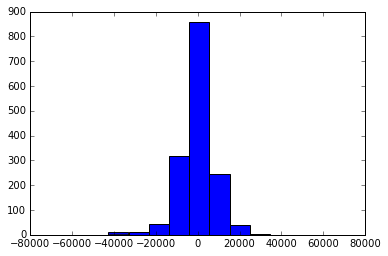

Distribution of prediction error on test data:


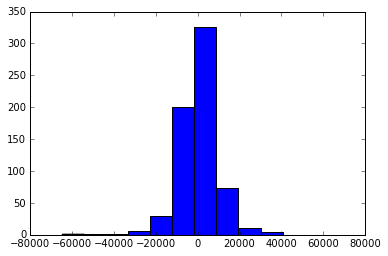

In [15]:
### MODEL PERFORMANCE - LINEAR REGRESSION ###

# The Mean Squared Error
print("Mean Squared Error, training data: %d"
      % np.mean((regr.predict(X_train) - y_train) ** 2))
print("Mean Squared Error, test data: %d"
      % np.mean((regr.predict(X_test) - y_test) ** 2))
print(30 * '* ')

# Variance score
print('Variance score, training data: %.2f' % regr.score(X_train, y_train))
print('Variance score, test data: %.2f' % regr.score(X_test, y_test))
print(30 * '* ')

### GRAPHS: DISTRIBUTION OF ERROR ###
print('Distribution of prediction error on training data:')
predError = regr.predict(X_train) - y_train
plt.hist(predError)
plt.xlim(-80000, 80000)
plt.show()

print('Distribution of prediction error on test data:')
predError = regr.predict(X_test) - y_test
plt.hist(predError)
plt.xlim(-80000, 80000)
plt.show()

In [16]:
## LINEAR REGRESSION - NORMALIZED

from sklearn import datasets, linear_model
# DOC: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

regr_n = linear_model.LinearRegression(normalize = True)

# Train the model using the training sets
X_train_no_intercept = X_train
X_train = X_train.reshape(-1, X_train.shape[1])
regr_n.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

Mean Squared Error, training data: 64660299
Mean Squared Error, test data: 93279385
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
Variance score, training data: 0.80
Variance score, test data: 0.75
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
Distribution of prediction error on training data:


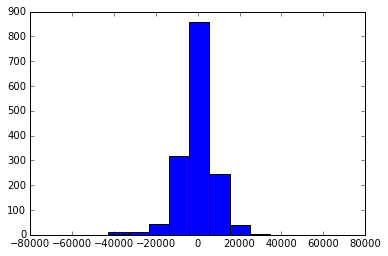

Distribution of prediction error on test data:


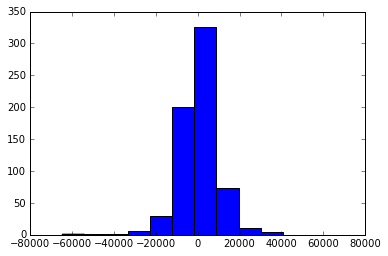

In [17]:
### MODEL PERFORMANCE - LINEAR REGRESSION ###

# The Mean Squared Error
print("Mean Squared Error, training data: %d"
      % np.mean((regr_n.predict(X_train) - y_train) ** 2))
print("Mean Squared Error, test data: %d"
      % np.mean((regr_n.predict(X_test) - y_test) ** 2))
print(30 * '* ')

# Variance score
print('Variance score, training data: %.2f' % regr_n.score(X_train, y_train))
print('Variance score, test data: %.2f' % regr_n.score(X_test, y_test))
print(30 * '* ')

### GRAPHS: DISTRIBUTION OF ERROR ###
print('Distribution of prediction error on training data:')
predError = regr_n.predict(X_train) - y_train
plt.hist(predError)
plt.xlim(-80000, 80000)
plt.show()

print('Distribution of prediction error on test data:')
predError = regr_n.predict(X_test) - y_test
plt.hist(predError)
plt.xlim(-80000, 80000)
plt.show()

In [18]:
## POLYNOMINAL 

from sklearn.preprocessing import PolynomialFeatures
# DOC: http://scikit-learn.org/stable/modules/preprocessing.html

poly = PolynomialFeatures(2)
X_poly = poly.fit_transform(X)

# create training and test sets
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
         X_poly, y, test_size=0.3, random_state=0)

# Create linear regression object
poly = linear_model.LinearRegression(normalize=True)

# Train the model using the training sets
X_train_no_intercept = X_train
X_train = X_train.reshape(-1, X_train.shape[1])
poly.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

Mean Squared Error, training data: 0
Mean Squared Error, test data: 9908494149
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
Variance score, training data: 1.00
Variance score, test data: -25.42
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
Distribution of prediction error on training data:


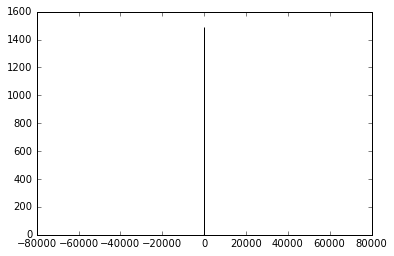

Distribution of prediction error on test data:


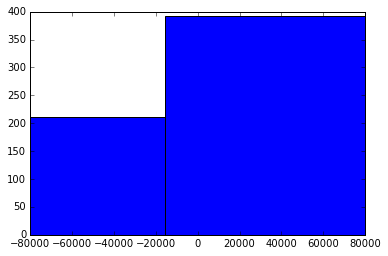

In [19]:
### MODEL PERFORMANCE ###

var_to_graph['poly'] = np.mean((poly.predict(X_test) - y_test) ** 2)

# The Mean Squared Error
print("Mean Squared Error, training data: %d"
      % np.mean((poly.predict(X_train) - y_train) ** 2))
print("Mean Squared Error, test data: %d"
      % np.mean((poly.predict(X_test) - y_test) ** 2))
print(30 * '* ')

# Variance score
print('Variance score, training data: %.2f' % poly.score(X_train, y_train))
print('Variance score, test data: %.2f' % poly.score(X_test, y_test))
print(30 * '* ')

### GRAPHS: DISTRIBUTION OF ERROR ###
print('Distribution of prediction error on training data:')
predError = poly.predict(X_train) - y_train
plt.hist(predError)
plt.xlim(-80000, 80000)
plt.show()

print('Distribution of prediction error on test data:')
predError = poly.predict(X_test) - y_test
plt.hist(predError)
plt.xlim(-80000, 80000)
plt.show()

In [20]:
## RIDGE REGRESSION
# DOC: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

# create training and test sets
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
         X, y, test_size=0.3, random_state=0)

# Create linear regression object
ridg = linear_model.Ridge()

# Train the model using the training sets
X_train_no_intercept = X_train
X_train = X_train.reshape(-1, X_train.shape[1])
ridg.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Mean Squared Error, training data: 66144772
Mean Squared Error, test data: 89629429
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
Variance score, training data: 0.79
Variance score, test data: 0.76
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
Distribution of prediction error on training data:


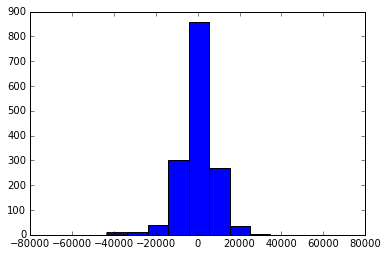

Distribution of prediction error on test data:


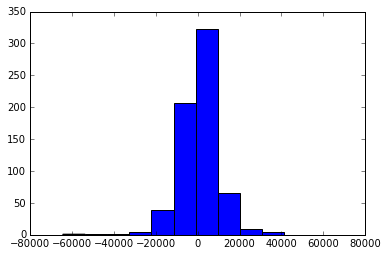

In [21]:
### MODEL PERFORMANCE - RIDGE ###

var_to_graph['ridge'] = np.mean((ridg.predict(X_test) - y_test) ** 2)

# The Mean Squared Error
print("Mean Squared Error, training data: %d"
      % np.mean((ridg.predict(X_train) - y_train) ** 2))
print("Mean Squared Error, test data: %d"
      % np.mean((ridg.predict(X_test) - y_test) ** 2))
print(30 * '* ')

# Variance score
print('Variance score, training data: %.2f' % ridg.score(X_train, y_train))
print('Variance score, test data: %.2f' % ridg.score(X_test, y_test))
print(30 * '* ')

### GRAPHS: DISTRIBUTION OF ERROR ###
print('Distribution of prediction error on training data:')
predError = ridg.predict(X_train) - y_train
plt.hist(predError)
plt.xlim(-80000, 80000)
plt.show()

print('Distribution of prediction error on test data:')
predError = ridg.predict(X_test) - y_test
plt.hist(predError)
plt.xlim(-80000, 80000)
plt.show()

In [22]:
## RIDGE REGRESSION - NORMALIZED
# DOC: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

# create training and test sets
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
         X, y, test_size=0.3, random_state=0)

# Create linear regression object
ridg_n = linear_model.Ridge(normalize=True)

# Train the model using the training sets
X_train_no_intercept = X_train
X_train = X_train.reshape(-1, X_train.shape[1])
ridg_n.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001)

Mean Squared Error, training data: 95260007
Mean Squared Error, test data: 111733355
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
Variance score, training data: 0.70
Variance score, test data: 0.70
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
Distribution of prediction error on training data:


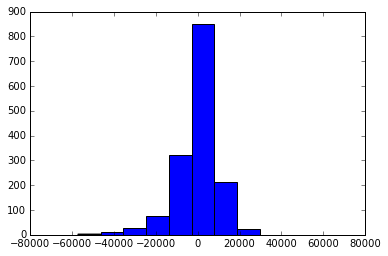

Distribution of prediction error on test data:


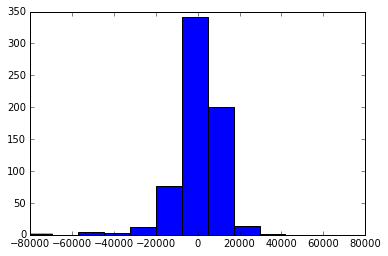

In [23]:
### MODEL PERFORMANCE - RIDGE NORMALIZED ###

var_to_graph['ridge_norm'] = np.mean((ridg_n.predict(X_test) - y_test) ** 2)

# The Mean Squared Error
print("Mean Squared Error, training data: %d"
      % np.mean((ridg_n.predict(X_train) - y_train) ** 2))
print("Mean Squared Error, test data: %d"
      % np.mean((ridg_n.predict(X_test) - y_test) ** 2))
print(30 * '* ')

# Variance score
print('Variance score, training data: %.2f' % ridg_n.score(X_train, y_train))
print('Variance score, test data: %.2f' % ridg_n.score(X_test, y_test))
print(30 * '* ')

### GRAPHS: DISTRIBUTION OF ERROR ###
print('Distribution of prediction error on training data:')
predError = ridg_n.predict(X_train) - y_train
plt.hist(predError)
plt.xlim(-80000, 80000)
plt.show()

print('Distribution of prediction error on test data:')
predError = ridg_n.predict(X_test) - y_test
plt.hist(predError)
plt.xlim(-80000, 80000)
plt.show()

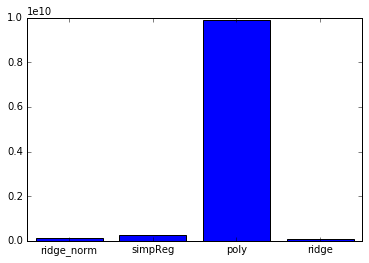

In [24]:
# bar graph of dict with Residual Sum of Squares on test datasets

#var_to_graph['multReg_poly'] = 0
plt.bar(range(len(var_to_graph)), var_to_graph.values(), align='center')
plt.xticks(range(len(var_to_graph)), var_to_graph.keys())

plt.show()

Mean Squared Error, training data: 66144772
Mean Squared Error, test data: 89629429
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
Variance score, training data: 0.79
Variance score, test data: 0.76
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
Distribution of prediction error on training data:


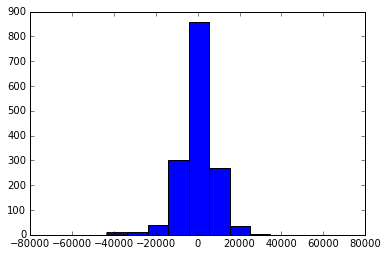

Distribution of prediction error on test data:


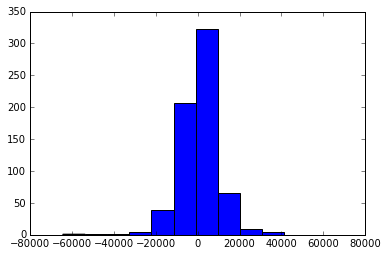

In [25]:
## BEST MODEL: RIDGE - NON-NORMALIZED

### MODEL PERFORMANCE - RIDGE ###

var_to_graph['ridge'] = np.mean((ridg.predict(X_test) - y_test) ** 2)

# The Mean Squared Error
print("Mean Squared Error, training data: %d"
      % np.mean((ridg.predict(X_train) - y_train) ** 2))
print("Mean Squared Error, test data: %d"
      % np.mean((ridg.predict(X_test) - y_test) ** 2))
print(30 * '* ')

# Variance score
print('Variance score, training data: %.2f' % ridg.score(X_train, y_train))
print('Variance score, test data: %.2f' % ridg.score(X_test, y_test))
print(30 * '* ')

### GRAPHS: DISTRIBUTION OF ERROR ###
print('Distribution of prediction error on training data:')
predError = ridg.predict(X_train) - y_train
plt.hist(predError)
plt.xlim(-80000, 80000)
plt.show()

print('Distribution of prediction error on test data:')
predError = ridg.predict(X_test) - y_test
plt.hist(predError)
plt.xlim(-80000, 80000)
plt.show()